In [47]:
import pandas as pd
import numpy as np 
import scipy
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# 1. Model definitions

## 1.1 Logistic regression

In [48]:
def sigmoid(x):    
    g=1/(1+np.exp(-x))
    return g

def gradient_descent(theta, features, target, lr, num_steps):
    log_likelihood_history = np.zeros(num_steps)
    
    for step in range(num_steps):
        # compute and store the log_likelihood value
        hypothesis = sigmoid(theta.dot(features.T))
        log_likelihood_history[step] = np.sum(target*np.log(hypothesis)+(1-target)*np.log(1-hypothesis))/features.shape[0]
        #update theta to do the gradient descent 
        theta -= lr * (-np.sum((target - sigmoid(theta.dot(features.T)))[:,np.newaxis] * features, axis=0) / features.shape[0])

    return theta, log_likelihood_history

def accuracy(theta, X, y):

    predictions = np.where(sigmoid(theta.dot(X.T)) >= 0.5, 1, 0)
    accuracy = np.sum(predictions == y)/y.shape[0]
    
    return accuracy

## 1.2 Naive Bayes

In [49]:
class BernoulliNaiveBayes():

    
    def __init__(self):
        self.fitted = False
  

    def fit(self, x_train, y_train):
        self.fitted = False
        self.x_train, self.y_train = x_train, y_train
        self.n_samples, self.n_features = x_train.shape
        self.features_count = np.zeros((2, self.n_features))
        for cls in [0,1]:
            self.features_count[cls] = np.sum(x_train[y_train==cls], axis=0)
        self.fitted = True
        
        
    # P(Y)
    def __prior(self, cls):
        return np.sum(y_train==cls)/self.n_samples
        
        
    # P(X_i | Y_i)
    def __feature_likelihood(self, x_i, i, cls, alpha=0.1):
        p = (self.features_count[cls,i]) / (np.sum(self.y_train==cls))
        return (p**x_i) * ((1-p)**(1-x_i))
    
    
    # P(X | Y_i)
    def __likelihood(self, x, cls):
        return np.prod([self.__feature_likelihood(x[i],i,cls) for i in range(self.n_features)])
    
    
    # P(Y | X)
    def __posterior(self, x):
        total_prob = np.sum([self.__likelihood(x,cls)*self.__prior(cls) for cls in [0,1]]) 
        return self.__likelihood(x,1)*self.__prior(1)/total_prob
    
    
    def predict_proba(self, X_test):
        if not self.fitted:
            raise self.NotFittedError("Model not fitted, please call the fit method.")
        return np.array([self.__posterior(sample) for sample in X_test])
        
    
    def predict(self, X_test):
        return np.where(self.predict_proba(X_test) < 0.5, 0, 1)
    
    
    def score(self, X_test, Y_test):
        predictions = self.predict(X_test)
        return np.sum(predictions == Y_test) / np.sum(Y_test.shape[0])
    
    
    class NotFittedError(BaseException):
        pass

# 2. Data preparation

In [50]:
df = pd.read_csv("covid_early_stage_symptoms.csv")
df.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,SARS-CoV-2 Positive
0,male,89,1,1,0,0,0,0,0,1,0,0
1,male,68,1,0,0,0,0,0,0,0,0,0
2,male,68,0,0,0,0,0,0,0,1,0,0
3,male,68,1,1,0,0,0,0,0,1,1,1
4,male,50,1,1,1,0,1,0,0,1,0,1


In [51]:
df['gender'].loc[df['gender'] == 'male'] = 0
df['gender'].loc[df['gender'] == 'female'] = 1

df['age_year'] = df['age_year'].apply(lambda x: 0 if x < 40 else 1)

df.head()

,gender,age_year,fever,cough,runny_nose,muscle_soreness,pneumonia,diarrhea,lung_infection,travel_history,isolation_treatment,SARS-CoV-2 Positive
0,0,1,1,1,0,0,0,0,0,1,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,0,0
3,0,1,1,1,0,0,0,0,0,1,1,1
4,0,1,1,1,1,0,1,0,0,1,0,1


In [52]:
df.groupby('SARS-CoV-2 Positive').describe()

age_year                                               \
                       count      mean       std  min  25%  50%  75%  max   
SARS-CoV-2 Positive                                                         
0                     4940.0  0.571457  0.494918  0.0  0.0  1.0  1.0  1.0   
1                     1572.0  0.618321  0.485953  0.0  0.0  1.0  1.0  1.0   

                      fever            ... travel_history       \
                      count      mean  ...            75%  max   
SARS-CoV-2 Positive                    ...                       
0                    4940.0  0.290081  ...            1.0  1.0   
1                    1572.0  0.790076  ...            1.0  1.0   

                    isolation_treatment                                     \
                                  count      mean       std  min  25%  50%   
SARS-CoV-2 Positive                                                          
0                                4940.0  0.162348  0.368807  0.0  0.0  0.0   
1                                1572.0  0.388677  0.487605  0.0  0.0  0.0   

                               
                     75%  max  
SARS-CoV-2 Positive            
0                    0.0  1.0  
1                    1.0  1.0  

[2 rows x 80 columns]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6512 entries, 0 to 6511
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               6512 non-null   object
 1   age_year             6512 non-null   int64 
 2   fever                6512 non-null   int64 
 3   cough                6512 non-null   int64 
 4   runny_nose           6512 non-null   int64 
 5   muscle_soreness      6512 non-null   int64 
 6   pneumonia            6512 non-null   int64 
 7   diarrhea             6512 non-null   int64 
 8   lung_infection       6512 non-null   int64 
 9   travel_history       6512 non-null   int64 
 10  isolation_treatment  6512 non-null   int64 
 11  SARS-CoV-2 Positive  6512 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 610.6+ KB


In [54]:
X = df.drop(['SARS-CoV-2 Positive'], axis = 1, inplace = False).to_numpy(dtype = float)
y = df['SARS-CoV-2 Positive'].to_numpy(dtype = int)
# normalize
Z = preprocessing.StandardScaler().fit_transform(X) 
# ACP
pca = PCA(n_components=Z.shape[1])
A = pca.fit_transform(Z)

# 3. Performance
### Confusion Matrix, Accuracy and Recall

We compute confusion matrix for each model we made to compare their performance. 
Then, we do a score-based evaluation by computing the sensitivity (a.k.a recall) and accuracy.

\begin{bmatrix}
TP & FP  \\
FN & TN 
\end{bmatrix}

$Accuracy = \frac{TP + TN}{m}$

$Recall = \frac{TP}{TP + FN}$

## 3.1 Logistic regression

In [35]:
# Prepare test data
#x = np.hstack([np.ones((A.shape[0], 1)), A])
x_train,x_test,y_train,y_test=train_test_split(A,y,random_state=4,test_size=0.2)

[-1.09702259  1.93026375 -0.77659223]


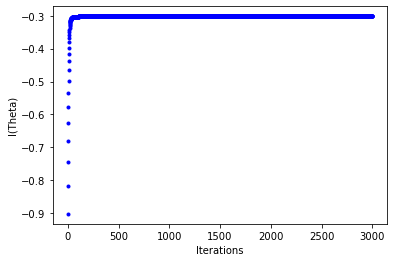

In [36]:
# Initialize theta0
theta0 = np.ones(x_train.shape[1])

# Run Gradient Ascent method
n_iter=3000
theta_final, log_l_history = gradient_descent(theta0, x_train, y_train, lr=0.5, num_steps=n_iter)
print(theta_final)

fig,ax = plt.subplots(num=2)

ax.set_ylabel('l(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(log_l_history)),log_l_history,'b.')

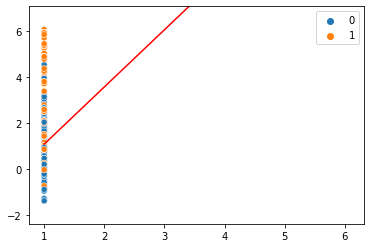

In [37]:
# Generate vector to plot decision boundary
x1_vec = np.linspace(x_train[:,0].min(),x_train[:,1].max(),2)

# Plot raw data
sns.scatterplot(x=x_train[:,0], y=x_train[:,1], hue=y_train)

# Plot decision boundary
plt.plot(x1_vec,(-x1_vec*theta_final[1]-theta_final[0])/theta_final[2], color="red")
plt.ylim(x_train[:,1].min()-1,x_train[:,1].max()+1)
# Save the theta_final value for later comparisons
theta_GA = theta_final.copy()

In [38]:
print('accuracy is :', accuracy(theta_final, x_test, y_test))

accuracy is : 0.8534151957022257


#### Compare with the python library LogisticRegression

In [39]:
# fit data to LR model
lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)

preds = lr.predict(x_test)
print('accuracy is',accuracy_score(y_test,preds))

accuracy is 0.8534151957022257


In [40]:
# LR with linear boundary 
from sklearn.metrics import confusion_matrix

predictions = np.where(sigmoid(theta_final.dot(x_test.T))>=0.5,1,0)
cm = confusion_matrix(y_test, predictions)

recall = cm[0,0]/(cm[0,0] + cm[0,1])
print(cm, '\n', 'recall score is: {} '.format(recall))

[[940  42]
 [149 172]] 
 recall score is: 0.9572301425661914 


## 3.2 Multinomial logistic regression

In [14]:
Z = preprocessing.StandardScaler().fit_transform(X) # normalize

pca = PCA(n_components=2)
A = pca.fit_transform(Z)

A = np.hstack([np.ones((A.shape[0], 1)), A])

In [15]:
def new_features(x, degree=2):
    # represent the vector x0 of ones
    features = np.ones(x[:,1].shape[0])
    #store and stack at the right the vectors x1 and x2 (with the right shape)
    x1,x2 = x[:,1], x[:,2]
    features = np.hstack([features.reshape(features.shape[0], 1), x1.reshape(x1.shape[0], 1)])
    features = np.hstack([features, x2.reshape(x2.shape[0], 1)])

    # for each degree (2 or 3 or more) we stack every possible combination between x1 and x2 (sum of powers = degree = i)
    for i in range(2, degree+1):
        for j in range(i+1) :
            x=(x1**(i-j))*(x2**(j))
            features = np.hstack([features, x.reshape(x.shape[0], 1)])
    
    return features


In [16]:
x_new_quad = new_features(A, degree=2)
x_new_cubic = new_features(A, degree=3)

#reordering output features
temp = np.copy(x_new_quad[:, -1])
x_new_quad[:, -1] = x_new_quad[:, -2]
x_new_quad[:, -2] = temp

temp = np.copy(x_new_cubic[:, -1])
x_new_cubic[:, -1] = x_new_cubic[:, -2]
x_new_cubic[:, -2] = x_new_cubic[:, -3]
x_new_cubic[:, -3] = temp

x_train, x_test ,y_train,y_test=train_test_split(A,y,random_state=4,test_size=0.2)
x_train_quad,x_test_quad,y_train,y_test=train_test_split(x_new_quad,y,random_state=4,test_size=0.2)
x_train_cubic,x_test_cubic,y_train,y_test=train_test_split(x_new_cubic,y,random_state=4,test_size=0.2)

In [17]:
# Initialize theta0, in case of quadratic features
theta0_quad = np.zeros(x_train_quad.shape[1])

theta_final_quad, log_l_history_quad = gradient_descent(theta0_quad,x_train_quad,y_train,lr=0.01,num_steps=n_iter)

# Initialize theta0, in case of quadratic and cubic features
theta0_cubic = np.zeros(x_train_cubic.shape[1])

# Run Newton's method, in case of quadratic and cubic features
theta_final_cubic, log_l_history_cubic = gradient_descent(theta0_cubic,x_train_cubic,y_train,lr=0.01,num_steps=n_iter)

# check and compare with previous results
print(theta_final_quad)
print(theta_final_cubic)

[-0.97631862  1.66766374 -0.11914946 -0.1651253  -0.09291426 -0.16892655]
[-0.64375005  1.25118884 -0.08125503 -0.82990586  0.02494826  0.00821261
  0.17632106 -0.16114057  0.06394702  0.17548766]


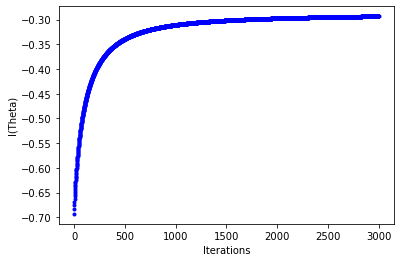

In [18]:
# Plot the log likelihood values in the optimization iterations, in one of the two cases.
fig,ax = plt.subplots(num=2)

ax.set_ylabel('l(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(log_l_history_quad)),log_l_history_quad,'b.')

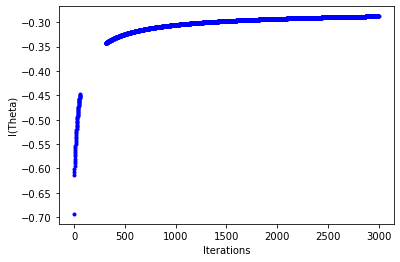

In [19]:
# Plot the log likelihood values in the optimization iterations, in one of the two cases.
fig,ax = plt.subplots(num=2)

ax.set_ylabel('l(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(log_l_history_quad)),log_l_history_cubic,'b.')

In [20]:
def boundary_function(x1_vec, x2_vec, theta_final):
    
    x1_vec, x2_vec = np.meshgrid(x1_vec,x2_vec)
    x1 = x1_vec
    x2 = x2_vec
    
    if len(theta_final) == 6:
        # boundary function value for features up to quadratic
        c_0, c_1, c_2, c_3, c_4, c_5 = theta_final
        f = c_0 + c_1*x1 + c_2*x2 + c_3*(x1**2) + c_4*(x2**2) + c_5*x1*x2
    elif len(theta_final) == 10:
        # boundary function value for features up to cubic
        c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9 = theta_final
        f = c_0 + c_1*x1 + c_2*x2 + c_3*(x1**2) + c_4*(x2**2) + c_5*x1*x2 + c_6*(x1**3) + c_7*(x2**3) + c_8*(x1**2)*x2+ c_9*x1*(x2**2)
    else:
        raise("Number of Parameters is not correct")
        
    return x1_vec, x2_vec, f

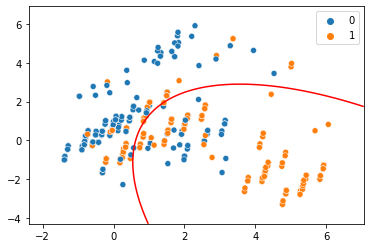

In [21]:
x1_vec = np.linspace(x_train_quad[:,1].min()-1,x_train[:,1].max()+1,200);
x2_vec = np.linspace(x_train_quad[:,2].min()-1,x_train[:,2].max()+1,200);

x1_vec, x2_vec, f = boundary_function(x1_vec, x2_vec, theta_final_quad)

sns.scatterplot(x=x_train_quad[:,1], y=x_train_quad[:,2], hue=y_train);

plt.contour(x1_vec, x2_vec, f, colors="red", levels=[0])
plt.show()


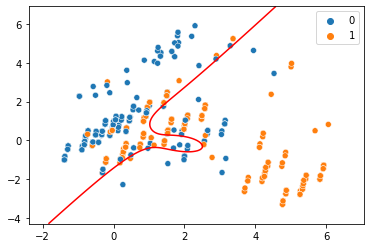

In [22]:
x1_vec = np.linspace(x_train_cubic[:,1].min()-1,x_train_cubic[:,1].max()+1,200);
x2_vec = np.linspace(x_train_cubic[:,2].min()-1,x_train_cubic[:,2].max()+1,200);

x1_vec, x2_vec, f = boundary_function(x1_vec, x2_vec, theta_final_cubic)

sns.scatterplot(x=x_train_cubic[:,1], y=x_train_cubic[:,2], hue=y_train);

plt.contour(x1_vec, x2_vec, f, colors="red", levels=[0])
plt.show()


In [23]:
print('quadratic accuracy is :', accuracy(theta_final_quad, x_test_quad, y_test))
print('cubic accuracy is :', accuracy(theta_final_cubic, x_test_cubic, y_test))

quadratic accuracy is : 0.8495778971603991
cubic accuracy is : 0.8434382194934766


#### Compare with the python library LogisticRegression

In [24]:
# fit data to LR model
lr = LogisticRegression()
lr.fit(x_train, y_train)

preds = lr.predict(x_test)
print('accuracy is',accuracy_score(y_test,preds))

accuracy is 0.8534151957022257


In [41]:
# LR with quadratic boundary

predictions = np.where(sigmoid(theta_final_quad.dot(x_test_quad.T))>=0.5,1,0)
cm = confusion_matrix(y_test, predictions)
recall = cm[0,0]/(cm[0,0] + cm[0,1])
print(cm, '\n', 'recall score is: {} '.format(recall))

[[956  26]
 [170 151]] 
 recall score is: 0.9735234215885947 


In [42]:
# LR with cubic boundary 

predictions = np.where(sigmoid(theta_final_cubic.dot(x_test_cubic.T))>=0.5,1,0)
cm = confusion_matrix(y_test, predictions)
recall = cm[0,0]/(cm[0,0] + cm[0,1])
print(cm, '\n', 'recall score is: {} '.format(recall))

[[964  18]
 [186 135]] 
 recall score is: 0.9816700610997964 


## 3.3 Naive Bayes

In [44]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=4,test_size=0.2)

model = BernoulliNaiveBayes()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.8365310821181888

#### Compare with the python library LogisticRegression

In [26]:
# Compare with sklearn
sk_model = BernoulliNB()
sk_model.fit(x_train, y_train)
sk_model.score(x_test, y_test)

0.8365310821181888

In [45]:
# Naive Bayes

model = BernoulliNaiveBayes()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
cm = confusion_matrix(y_test, predictions)
recall = cm[0,0]/(cm[0,0] + cm[0,1])
print(cm, '\n', 'recall score is: {} '.format(recall))

[[860 122]
 [ 91 230]] 
 recall score is: 0.8757637474541752 
